In [15]:
%reset -f

wvfm_dir = '/home/userqy/20250328_Myanmar_M7.7/all_wvfms'
outdir = '/home/userqy/20250328_Myanmar_M7.7/bp/global'

evdp = 15 # Event depth
evlo = 95.9258  # Event longitude
evla = 21.9963  # Event latitude

station_list = '/home/userqy/20250328_Myanmar_M7.7/all_wvfms/list_z_tele_PF.txt'
phasename = 'P'


In [16]:
import os
import numpy as np

def y_rdfile_phasefile_v2(phasefile):
    """
    Reads a phase file saved from the crazyseismic software and extracts the data.

    Parameters:
        phasefile (str): Path to the phase file.

    Returns:
        dict: A dictionary containing the extracted data.
    """


    # Initialize the output dictionary
    phase = {}

    # Check if the file exists
    if not os.path.exists(phasefile):
        phase['filename'] = []
        return phase

    # Read the file
    with open(phasefile, 'r') as fid:
        lines = fid.readlines()

    # Initialize lists to store data
    filename = []
    theo_tt = []
    tshift = []
    obs_tt = []
    polarity = []
    stnm = []
    netwk = []
    rayp = []
    stla = []
    stlo = []
    stel = []
    evla = []
    evlo = []
    evdp = []
    dist = []
    az = []
    baz = []
    snr0 = []
    xcoeff0 = []

    # Parse each line
    for line in lines:
        # Skip comment lines
        if line.startswith('#'):
            continue

        # Split the line into components
        parts = line.split()

        # Ensure the line has enough columns
        if len(parts) < 19:
            continue

        # Extract data
        filename.append(parts[0])
        theo_tt.append(float(parts[1]))
        tshift.append(float(parts[2]))
        obs_tt.append(float(parts[3]))
        polarity.append(float(parts[4]))
        stnm.append(parts[5])
        netwk.append(parts[6])
        rayp.append(float(parts[7]))
        stla.append(float(parts[8]))
        stlo.append(float(parts[9]))
        stel.append(float(parts[10]))
        evla.append(float(parts[11]))
        evlo.append(float(parts[12]))
        evdp.append(float(parts[13]))
        dist.append(float(parts[14]))
        az.append(float(parts[15]))
        baz.append(float(parts[16]))
        snr0.append(float(parts[17]))
        xcoeff0.append(float(parts[18]))

    # Check if the file is empty or not a phasefile
    if not filename:
        phase['filename'] = []
        return phase

    # Store data in the dictionary
    phase['filename'] = np.array(filename)
    phase['theo_tt'] = np.array(theo_tt)
    phase['tshift'] = np.array(tshift)
    phase['obs_tt'] = np.array(obs_tt)
    phase['polarity'] = np.array(polarity)
    phase['stnm'] = np.array(stnm)
    phase['netwk'] = np.array(netwk)
    phase['rayp'] = np.array(rayp)
    phase['stla'] = np.array(stla)
    phase['stlo'] = np.array(stlo)
    phase['stel'] = np.array(stel)
    phase['evla'] = np.array(evla)
    phase['evlo'] = np.array(evlo)
    phase['evdp'] = np.array(evdp)
    phase['dist'] = np.array(dist)
    phase['az'] = np.array(az)
    phase['baz'] = np.array(baz)
    phase['snr0'] = np.array(snr0)
    phase['xcoeff0'] = np.array(xcoeff0)

    return phase

def filter_waveforms_by_azimuth(phase_data, az_min, az_max, azimuth_threshold):
    
    print (azimuth_threshold)
    
    az = phase_data['az']
    xcoeff0 = phase_data['xcoeff0']
    keys = phase_data.keys()

    valid_indices = np.where((az >= az_min) & (az <= az_max))[0]
    az_filtered = az[valid_indices]
    xcoeff0_filtered = xcoeff0[valid_indices]
    
    sorted_indices = np.argsort(az_filtered)
    az_sorted = az_filtered[sorted_indices]
    xcoeff0_sorted = xcoeff0_filtered[sorted_indices]

    filtered_indices = []

    i = 0
    while i < len(az_sorted):
        current_az = az_sorted[i]
        group_indices = np.where(np.abs(az_sorted - current_az) <= azimuth_threshold)[0]
        best_index_in_group = group_indices[np.argmax(xcoeff0_sorted[group_indices])]
        filtered_indices.append(valid_indices[sorted_indices[best_index_in_group]])
        i = group_indices[-1] + 1

    for key in keys:
        phase_data[key] = phase_data[key][filtered_indices]
    
    return phase_data

def write_phasefile(phase_data, output_file):
    """
    Write filtered phase data back to a file.

    Parameters:
        phase_data (dict): Filtered phase dictionary from y_rdfile_phasefile_v2.
        output_file (str): Output file path to save the filtered data.
    """
    with open(output_file, 'w') as f:
        for i in range(len(phase_data['filename'])):
            line = (
                f"{phase_data['filename'][i]} {phase_data['theo_tt'][i]:.4f} {phase_data['tshift'][i]:.4f} "
                f"{phase_data['obs_tt'][i]:.4f} {phase_data['polarity'][i]:.1f} {phase_data['stnm'][i]} {phase_data['netwk'][i]} "
                f"{phase_data['rayp'][i]:.4f} {phase_data['stla'][i]:.4f} {phase_data['stlo'][i]:.4f} {phase_data['stel'][i]:.1f} "
                f"{phase_data['evla'][i]:.4f} {phase_data['evlo'][i]:.4f} {phase_data['evdp'][i]:.1f} {phase_data['dist'][i]:.3f} "
                f"{phase_data['az'][i]:.2f} {phase_data['baz'][i]:.2f} {phase_data['snr0'][i]:.2f} {phase_data['xcoeff0'][i]:.2f}\n"
            )
            f.write(line)

In [17]:
# filter stations
import numpy as np

phaseP = y_rdfile_phasefile_v2(station_list)
print(len(phaseP['filename']))

filter_waveforms_by_azimuth(phaseP, 0, 360, 3)
nsta = len(phaseP['filename'])

new_station_list = '/home/userqy/20250328_Myanmar_M7.7/all_wvfms/list_z_tele_filter_PF.txt'
write_phasefile(phaseP, new_station_list)

print(nsta)
#print(phaseP['az'])
#for i in range(nsta):
#    print(f"{phaseP['stlo'][i]} {phaseP['stla'][i]}")

1004
3
65


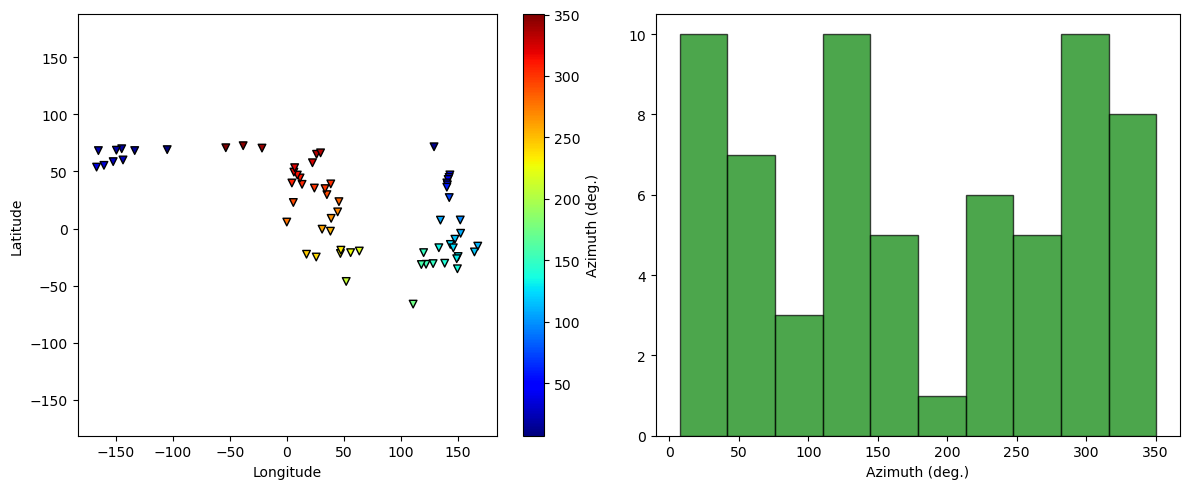

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
 
# seismic station plotting
plt.subplot(1, 2, 1)
sc = plt.scatter(phaseP['stlo'], phaseP['stla'], c=phaseP['az'], cmap='jet', marker='v', edgecolors='k', alpha=1,s=30)
plt.colorbar(sc, label='Azimuth (deg.)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('equal')

plt.subplot(1, 2, 2)
plt.hist(phaseP['az'], bins=10, color='g', alpha=0.7, edgecolor='black')
plt.xlabel('Azimuth (deg.)')

plt.tight_layout()
plt.show()

grids finished
95.532588 96.319012 18.537786 23.523436


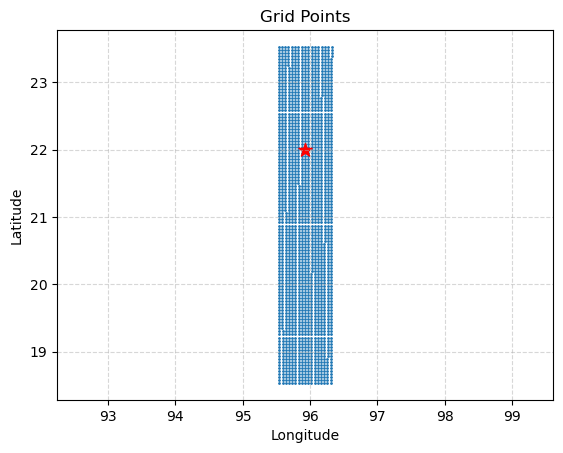

In [19]:
# source grids
# Parameters
interval = 5  # Grid spacing in kilometers
length_e = 50
length_w = 50
length_s= 380  # East-West extent of the grid in kilometers
length_n = 170  # South-North extent of the grid in kilometers

# Constants
earth_radius_equator = 6378.137  # Earth's radius at the equator in kilometers
earth_radius_polar = 6356.752  # Earth's radius at the poles in kilometers
deg_to_km = np.pi * earth_radius_equator / 180  # Conversion factor: degrees to kilometers
km_to_deg = 1 / deg_to_km  # Conversion factor: kilometers to degrees

# Calculate the number of latitude points
number_lat_s = int(length_s / interval) + 1
number_lat_n = int(length_n / interval) + 1

# Calculate latitude intervals in degrees
interval_in_deg_lat = interval * km_to_deg
dy = evla + interval_in_deg_lat * np.arange(-number_lat_s, number_lat_n)

# Open the output file
with open(os.path.join(outdir, 'grid.txt'), 'w') as fid:
    # Write the event location as the first line
    fid.write(f"{evlo:.6f} {evla:.6f}\n")
    
    # Loop through each latitude
    for i in range(number_lat_s + number_lat_n):
        y = dy[i]  # Current latitude
        # Calculate the number of longitude points for this latitude
        number_lon_e = int(length_e * np.cos(np.radians(y)) / interval)
        number_lon_w = int(length_w * np.cos(np.radians(y)) / interval)
        # Calculate longitude intervals in degrees for this latitude
        interval_in_deg_lon = interval / (np.pi * earth_radius_polar / 180 * np.cos(np.radians(y)))
        # Loop through each longitude
        for j in range(number_lon_e+number_lon_w - 1):
            x = evlo + interval_in_deg_lon * (j - number_lon_w +1)  # Current longitude
            fid.write(f"{x:.6f} {y:.6f}\n")   # Write the grid point to the file

# Read grids
grids = np.loadtxt(os.path.join(outdir, 'grid.txt'))
sx = grids[:, 0]
sy = grids[:, 1]
len_grids = len(grids)
print('grids finished')
print(np.min(sx),np.max(sx),np.min(sy),np.max(sy))


# girds visualization

import matplotlib.pyplot as plt

grids = np.loadtxt(os.path.join(outdir, 'grid.txt'), skiprows=1)
plt.scatter(sx, sy, s=1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, linestyle='--', alpha=0.5)
plt.scatter(evlo, evla, s=100, color='red', marker='*')
plt.axis('equal') 
plt.title('Grid Points')
plt.show()

In [20]:
# Traveltime between receivers and grids
from obspy.taup import TauPyModel
from pyproj import Geod
from obspy.geodetics import kilometers2degrees
from multiprocessing import cpu_count, get_context

model = TauPyModel(model='ak135')
geod = Geod(ellps="WGS84")  # WGS84

def compute_travel_time(m):
    tt_m = np.zeros(nsta)
    for i in range(nsta):
        _, _, dist = geod.inv(phaseP['stlo'][i], phaseP['stla'][i], sx[m], sy[m])
        dist = kilometers2degrees(dist/1000)
        arrivals = model.get_travel_times(source_depth_in_km=evdp, distance_in_degree=dist, phase_list=[phasename])
        tt_m[i] = arrivals[0].time if arrivals else np.nan
    return tt_m

if __name__ == "__main__":
    with get_context("fork").Pool(processes=cpu_count()) as pool:
        tt_list = pool.map(compute_travel_time, range(len_grids))

    tt = np.array(tt_list)
    print('Traveltime calculation finished')

Traveltime calculation finished


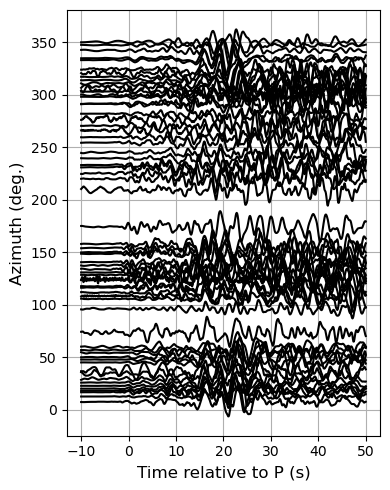

In [21]:
# wvfm plotting

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from obspy import read
import os

fl = 0.2
fh = 2
order = 2
delta = 0.1  # resample
tw = np.arange(-10, 50 + delta, delta)

plt.figure(figsize=(4, 5))
plt.rcParams['font.size'] = 10

for i in range(nsta):
    st = read(os.path.join(wvfm_dir, phaseP['filename'][i]))
    tr = st[0]
    tr.detrend("demean");tr.detrend("linear");tr.taper(type='hann', max_percentage=0.05)
    tr.filter("bandpass", freqmin=fl, freqmax=fh, corners=order, zerophase=False)
    hd = tr.stats
    data = tr.data * phaseP['polarity'][i]
    
    time = np.linspace(hd.sac.b,hd.sac.e,hd.npts) - hd.sac.o - phaseP['obs_tt'][i] #tt[0,i] 
    # Resample data and time to the desired sampling rate
    new_num_samples = int(hd.npts * hd.delta / delta)
    interp_func = interp1d(time, data, kind='linear', fill_value='extrapolate')
    time = np.linspace(time.min(), time.max(), new_num_samples)
    data = interp_func(time)
    
    # cut
    data = interp1d(time, data, kind='linear', fill_value='extrapolate')(tw)

	# normalize
    data = data / np.max(np.abs(data))
    plt.plot(tw, hd.sac.az + data * 15, 'k-')


plt.xlabel('Time relative to P (s)', fontsize=12)
plt.ylabel('Azimuth (deg.)', fontsize=12)
plt.tight_layout()
plt.grid(True)

In [22]:
# waveform store

tw_alltmp = np.arange(-60, 200 + delta, delta)

data = np.zeros((len(tw_alltmp), nsta))
for i in range(nsta):
    st = read(os.path.join(wvfm_dir, phaseP['filename'][i]))
    tr = st[0]
    tr.detrend("demean");tr.detrend("linear");tr.taper(type='hann', max_percentage=0.05)
    tr.filter("bandpass", freqmin=fl, freqmax=fh, corners=order, zerophase=False)
    hd = tr.stats
    datatmp = tr.data * phaseP['polarity'][i]
    timetmp = np.linspace(hd.sac.b,hd.sac.e,hd.npts) - hd.sac.o - tt[0,i]
    
    # Resample data and time to the desired sampling rate
    new_num_samples = int(hd.npts * hd.delta / delta)
    interp_func = interp1d(timetmp, datatmp, kind='linear', fill_value='extrapolate')
    timetmp = np.linspace(timetmp.min(), timetmp.max(), new_num_samples)
    datatmp = interp_func(timetmp)
    
    # cut
    datatmp = interp1d(timetmp, datatmp, kind='linear', fill_value='extrapolate')(tw_alltmp)

	# normalize
    data[:,i] = datatmp / np.max(np.abs(datatmp))
    
print('waveform storage finished')

waveform storage finished


In [23]:
# Back-projection - shifting

win_all = 150
win_slide = 6
win_off = 1
n_win = int(win_all / win_off)
tw = np.linspace(-win_slide / 2, win_slide / 2, int(win_slide / delta) + 1)

# station correction
station_corr = phaseP['obs_tt']-tt[0,:]

def process_grid(m):
    datashift_m = np.zeros((len(tw), n_win, nsta))
    for i in range(nsta):
        interp_func = interp1d(tw_alltmp, data[:, i], kind='linear', fill_value='extrapolate')
        shifted_waveform = interp_func(tw_alltmp - tt[0, i] + tt[m, i] + station_corr[i])
        
        for j in range(n_win):
            jj = j - int(n_win / 5)
            j_tw = tw + win_off * jj
            datashifttmp = interp1d(tw_alltmp, shifted_waveform, kind='linear', fill_value='extrapolate')
            datashift_m[:, j, i] = datashifttmp(j_tw)
    return datashift_m


if __name__ == "__main__":
    datashift = np.zeros((len(tw), len_grids, n_win, nsta))  
    with get_context("fork").Pool(processes=cpu_count()) as pool:
        results = pool.map(process_grid, range(len_grids))

    for m, result in enumerate(results):
        datashift[:, m, :, :] = result
        
    print('shift finished')


shift finished


In [24]:
# Back-projection - stacking

from scipy.signal import hilbert
datatmp = np.zeros((len(tw), nsta))
data_stack = np.zeros((len_grids, n_win))
nthr = 4
npw = 1

for j in range(n_win):
    for m in range(len_grids):        
        datatmp = datashift[:, m, j, :]
        
        # cross-correlation weighted stacking
        #cc = np.corrcoef(datatmp.T)
        #np.fill_diagonal(cc, np.nan)
        #datatmp = datatmp * np.nanmean(cc, axis=1)
        
        # nthr root stack
        #datattmp = np.sign(datatmp) * np.abs(datatmp) ** (1 / nthr)
        #datattmp = np.mean(datattmp, axis=1, keepdims=True)
        #datattmp = np.sum(np.sign(datattmp) * np.abs(datattmp) ** nthr, axis=0) 
        #data_stack[m, j] = np.sum(datatmp ** 2)
        
        # linear stack
        #data_stack[m, j] = np.sum(np.sum(datatmp, axis=1) ** 2)
        
        # phase-weighted stacking
        hdata_shift = hilbert(datatmp, axis=0)
        hdata_shift /= np.abs(hdata_shift) 
        coh = np.abs(np.mean(hdata_shift, axis=1))
        datastack_pws = np.mean(datatmp, axis=1) * (coh ** npw)
        data_stack[m, j] =  np.sum(datastack_pws ** 2)
        
maxv = np.max(data_stack)

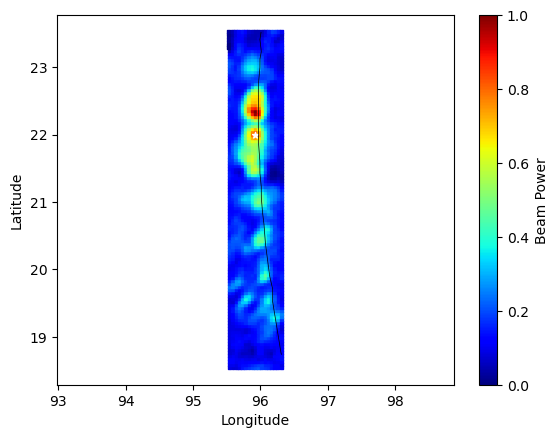

In [25]:
data = np.loadtxt('fault_surf_vel.txt')

sub_lon = data[:,0]
sub_lat = data[:,1]

energy = np.zeros(len_grids)
for m in range(len_grids):
    energy[m] = np.sum(data_stack[m,:]) ** 0.5

norm_energy =(energy - np.min(energy))/(np.max(energy - np.min(energy)))
sc = plt.scatter(sx, sy, c=norm_energy, cmap='jet',marker='s', s=4.5)
plt.colorbar(sc, label='Beam Power')
#contours = plt.contour(sx, sy, norm_energy, levels=20)

plt.plot(sub_lon,sub_lat,'k-',linewidth='0.5')
plt.scatter(sx[0],sy[0],marker='*',color='w',s=20)
#plt.scatter(sx[maxindex],sy[maxindex],marker='*',color='r',s=20,edgecolors='k')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('equal')
# plt.savefig(os.path.join(outdir, f"all_energy_{fl}-{fh}Hz.pdf"), format='pdf', dpi=300)
plt.show()

In [26]:
# Write out
with open(os.path.join(outdir, f"bp_1_{fl}-{fh}Hz.txt"), 'w') as fid1:
    for j in range(n_win):
        jj = j - int(n_win / 5)
        maxvj = np.max(data_stack[:, j])
        maxindex = np.argmax(data_stack[:, j])
        t_rupture = jj * win_off
        x = sx[maxindex]; y = sy[maxindex];
        _, _, dist = geod.inv(evlo, evla, sx[maxindex], sy[maxindex])
        fid1.write(f"{t_rupture:.1f} {maxvj / maxv:.2f} {sx[maxindex]:.3f} {sy[maxindex]:.3f} {dist/1000:.2f}\n")

with open(os.path.join(outdir, f"bp_2_{fl}-{fh}Hz.txt"), 'w') as fid:
    for m in range(len_grids):
        fid.write(f"{sx[m]} {sy[m]} {np.sum(data_stack[m, :])}\n")
        
print("written finished !!!")

written finished !!!
